# Mask Detection

## Information
- dataset : https://github.com/prajnasb/observations
- source : https://pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/
- blog : https://yscho03.tistory.com/87

## Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
tf.__version__

'2.3.0'

In [4]:
gpus = tf.config.experimental.list_logical_devices('GPU')
gpus

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [6]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
WITH_MASK_DIR = os.path.join(DATASET_DIR, 'with_mask')
WITHOUT_MASK_DIR = os.path.join(DATASET_DIR, 'without_mask')

## Load Dataset

In [7]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 # 0.0001
EPOCHS = 20
BS = 32

In [8]:
1e-4

0.0001

In [10]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

with_mask_paths = list(paths.list_images(WITH_MASK_DIR))
without_mask_paths = list(paths.list_images(WITHOUT_MASK_DIR))
image_paths = with_mask_paths + without_mask_paths

data = []
labels = []
# loop over the image paths
for image_path in image_paths:
	# extract the class label from the filename
	label = image_path.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(image_path, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


## Visualize the data

In [11]:
from pathlib import Path
import cv2

def show_images(sample_images):    
    _,ax = plt.subplots(2,2, figsize=(6,8))

    for i in range(len(sample_images)):
        img = cv2.imread(str(sample_images[i]))
        print("Shape of image: ", img.shape)
        ax[i//2, i%2].imshow(img)
        ax[i//2, i%2].axis('off')

>>> With Mask
Shape of image:  (350, 525, 3)
Shape of image:  (350, 525, 3)
Shape of image:  (350, 233, 3)
Shape of image:  (428, 320, 3)


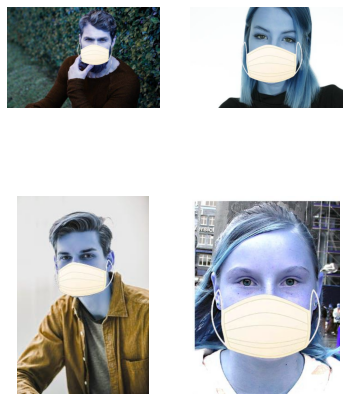

In [12]:
print('>>> With Mask')
show_images(with_mask_paths[:4])

>> Without Mask
Shape of image:  (270, 180, 3)
Shape of image:  (225, 154, 3)
Shape of image:  (366, 274, 3)
Shape of image:  (428, 320, 3)


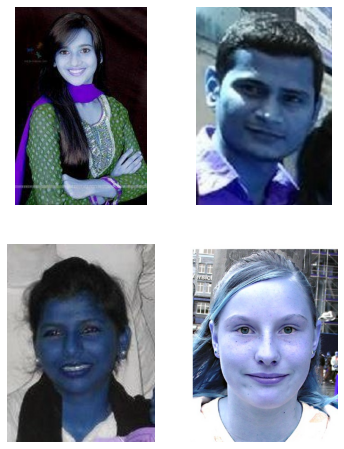

In [13]:
print('>> Without Mask')
show_images(without_mask_paths[:4])

In [14]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels.shape

(1376, 2)

In [16]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [17]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((1100, 224, 224, 3), (1100, 2), (276, 224, 224, 3), (276, 2))

In [19]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Build Model

In [20]:
def build_model():
    # load the MobileNetV2 network, ensuring the head FC layer sets are
    # left off
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    # False로 하면 layer weight가 변하지 않는다.
    for layer in baseModel.layers:
        layer.trainable = False
    return model

In [21]:
model = build_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [22]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [23]:
# Add early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_save_path = os.path.join(BASE_DIR, 'checkpoint', 'mask_model.ckpt')
checkpoint = ModelCheckpoint(checkpoint_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Training

In [24]:
# train the head of the network
print("[INFO] training head...")
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
    callbacks=[es])

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 31s 920ms/step - loss: 0.5160 - accuracy: 0.7566 - val_loss: 0.1297 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 27s 798ms/step - loss: 0.1358 - accuracy: 0.9654 - val_loss: 0.0545 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 31s 914ms/step - loss: 0.0776 - accuracy: 0.9860 - val_loss: 0.0404 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 27s 783ms/step - loss: 0.0540 - accuracy: 0.9850 - val_loss: 0.0277 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 27s 795ms/step - loss: 0.0465 - accuracy: 0.9878 - val_loss: 0.0263 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 29s 866ms/step - loss: 0.0363 - accuracy: 0.9897 - val_loss: 0.0205 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 27s 780ms/step - loss: 0.0284 - accuracy: 0.9944 - val_loss: 0.018

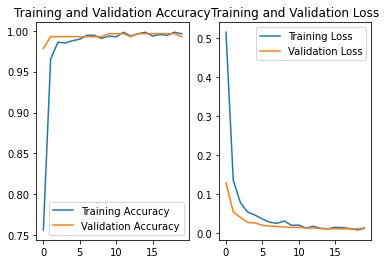

In [25]:
# Show acc and Loss curves for training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [26]:
print("[INFO] saving mask detector model...")
checkpoint_save_path = os.path.join(BASE_DIR, 'checkpoint', 'mask_model.h5')
model.save(checkpoint_save_path, save_format="h5")

[INFO] saving mask detector model...


## Inference

In [27]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


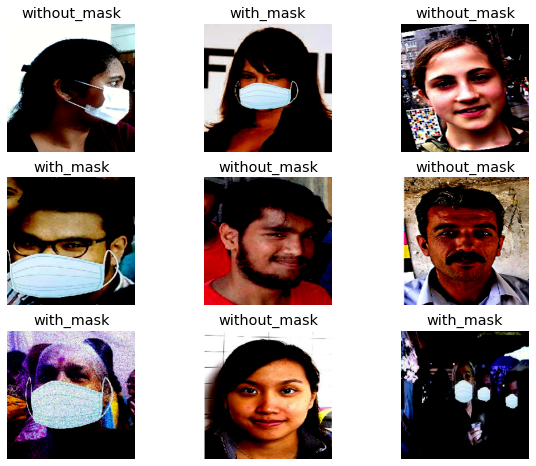

In [28]:
sample_X = testX[:9] 

sample_pred_idxs = model.predict(sample_X)
sample_pred_idxs = np.argmax(sample_pred_idxs, axis=1)

_,ax = plt.subplots(3,3, figsize=(10,8))
for i in range(len(sample_pred_idxs)):
    sample_pred = sample_pred_idxs[i]
    ax[i//3, i%3].set_title(lb.classes_[sample_pred])   
    ax[i//3, i%3].imshow(sample_X[i])    
    ax[i//3, i%3].axis('off')     

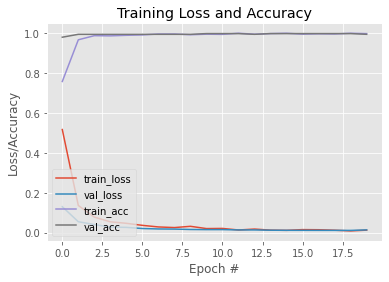

In [29]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")